In [1]:
import pandas as pd
import numpy as np
import sys
import os
import time
import random
import copy
import math
import scanpy as sc
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': "Helvetica",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }

mpl.rcParams.update(params)

sns.set_style("ticks")

savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
mpl.rc('savefig', dpi=300)
output_dir = "outs"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

data_dir = "../data/"

In [2]:
sc.set_figure_params(color_map='viridis')

## Analyze Cell Cycle status of Tabula Bursa

#### Load Data

In [3]:
# contains a portion of tabula bursa that my computer can handle and the B cells from swift et. al
adata = sc.read_h5ad('by_tissue_qc/outputs/bcells_BCD.h5ad')
adata.obs_names_make_unique(join="_")

/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### generally balance the cell types
This is not strictly, necessary but it helps prevent bias in identifying genes associated with the identities of cycling and non-cycling cells, rather than cell cylce per se

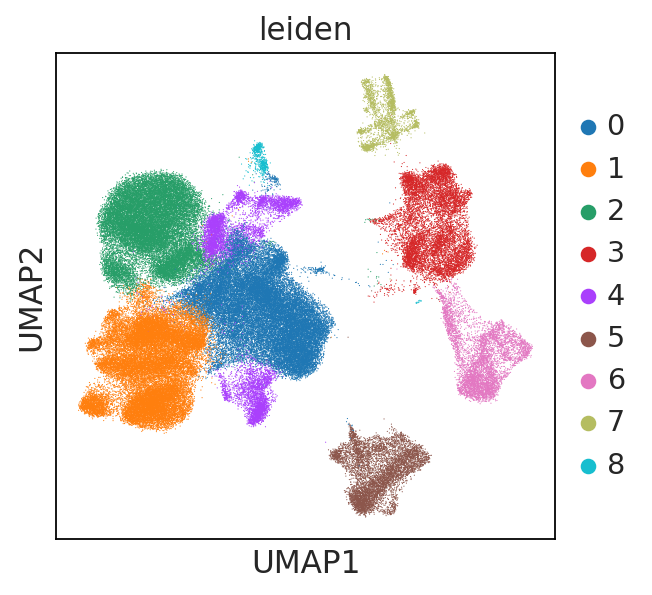

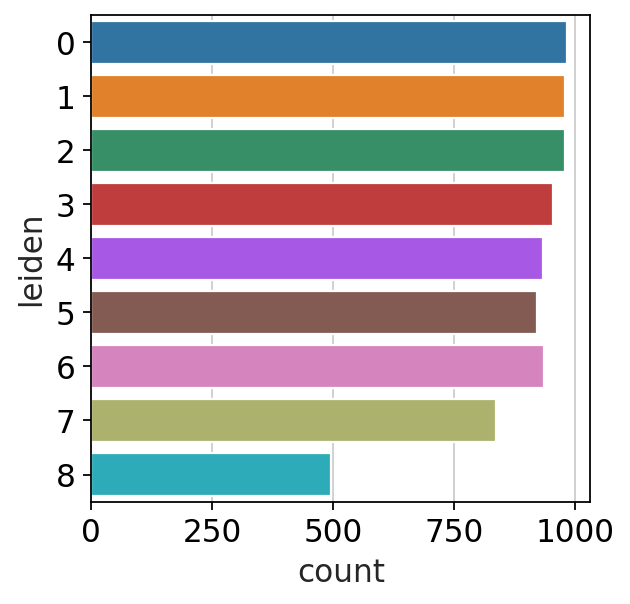

In [4]:
balance_celltypes = True
cluster = 'leiden'
#print(adata.obs[cluster].value_counts(), 'cells in current leiden clusters')
fig, ax = plt.subplots(1,1)
sns.countplot(data=adata.obs, y = adata.obs[cluster])
sc.pl.umap(adata, color = cluster)
if balance_celltypes:
    cell_names = adata.obs.groupby(cluster).sample(n=1000, replace=True).index
    adata = adata[adata.obs.index.isin(cell_names)]
    #print(adata.obs[cluster].value_counts(), 'more balanced cells in each cluster')
fig, ax = plt.subplots(1,1)
sns.countplot(data=adata.obs, y = adata.obs[cluster])
sc.pl.umap(adata, color = cluster)

# Annotation of cell cylce Using Gita's method

In [12]:
# Create cycling score:
#S markers
lst_sub_1 = ['ABHD10','CCDC14','CDKN2AIP','NT5DC1','SVIP','PTAR1']
#G2M markers
lst_sub_2 = ['SMC4','TMPO','LMNB1','HINT3']
#M markers
lst_sub_3 = ['HMG20B','HMGB3','HPS4']
#G2 markers
lst_sub_4 = ['ANKRD36C','YEATS4','DCTPP1']
#G1S marker
lst_sub_5 = ['CEP57','CDCA7L']
#G0 marker
lst_sub_6 = ['CDKN1A','CDKN1B','CDKN1C']

# How could the best score that you make be related to Gita's score, and how strongly expressed are these genes?
final_lst = lst_sub_1 + lst_sub_2 + lst_sub_3 + lst_sub_4 + lst_sub_5 + lst_sub_6
cycling = lst_sub_1 + lst_sub_2 + lst_sub_3 + lst_sub_4 + lst_sub_5 
sc.tl.score_genes(adata, cycling, score_name = 'cycling', use_raw=True)
sc.tl.score_genes(adata, lst_sub_6, score_name = 'non-cycling',use_raw=True)

def scoring(cycling, non_cycling):
    if cycling == non_cycling:
        decision = 'not clear'
    elif cycling > non_cycling:
        decision = 'cycling'
    else:   
        decision = 'non-cycling'
    return(decision)


#same as above but for total dataset
adata.obs['decision']= adata.obs.apply(lambda row: scoring(row['cycling'], row['non-cycling']), axis=1)
#collecting only cells for which a decision could be made
dataCyc10=adata[adata.obs['decision']!='not clear']
print('fraction of cells with clear calls:', dataCyc10.shape[0]/adata.shape[0])

adata.obs.decision.value_counts()

/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


fraction of cells with clear calls: 1.0


/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


cycling        4522
non-cycling    3500
Name: decision, dtype: int64

## Plot the Distributions of cell cycle scores

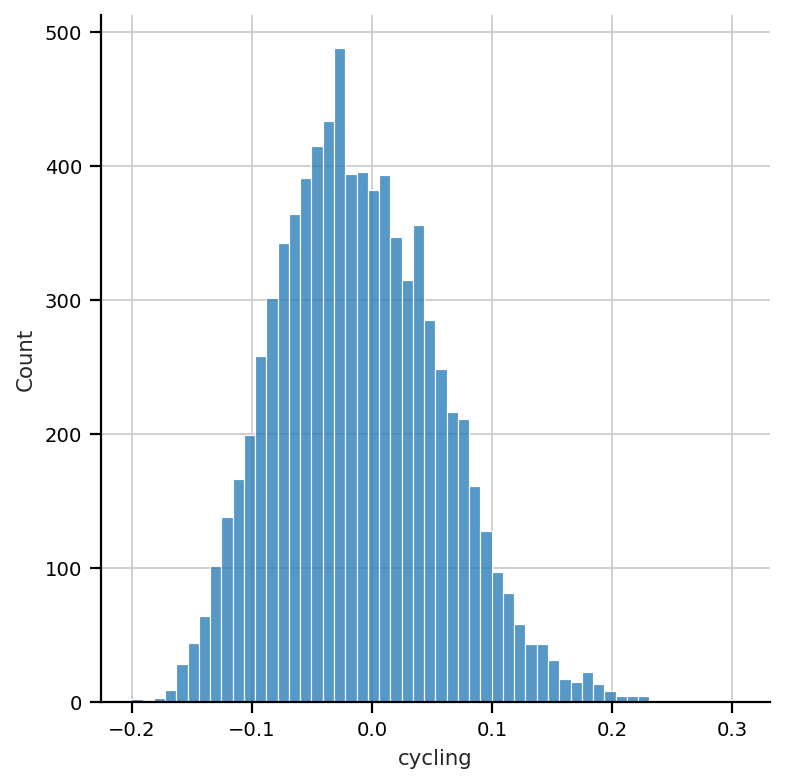

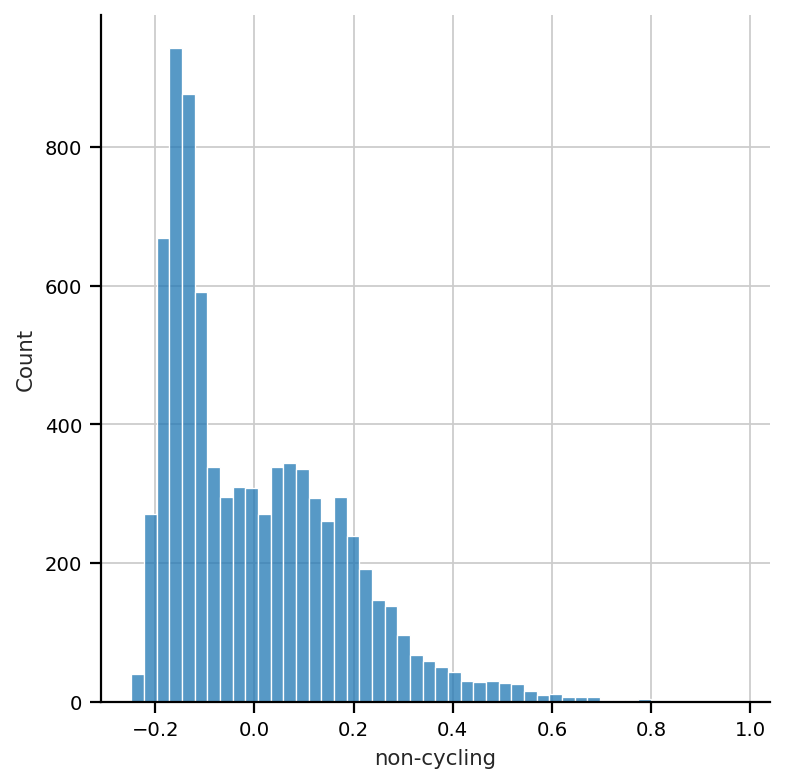

In [13]:
sns.displot(adata.obs['cycling'])
sns.displot(adata.obs['non-cycling'])

cycling score looks very noisy as it is centered around 0, non-cycling score seems to have 2 modes which is good

## plot cell type labels onto these histograms to see if it checks out with biology

In [14]:
# filter low abundance cell groups to clean up the plots (less lines)
# remove the dual labels
cell_group = 'majority_voting'
filter_low_abundance_cell_groups = True
adata.obs[cell_group] = adata.obs[cell_group].str.split("|", expand = True).iloc[:,0].astype('category')
if filter_low_abundance_cell_groups:
    select = adata.obs[cell_group].value_counts() > 100
    adata = adata[adata.obs[cell_group].isin(select[select == True].index)]

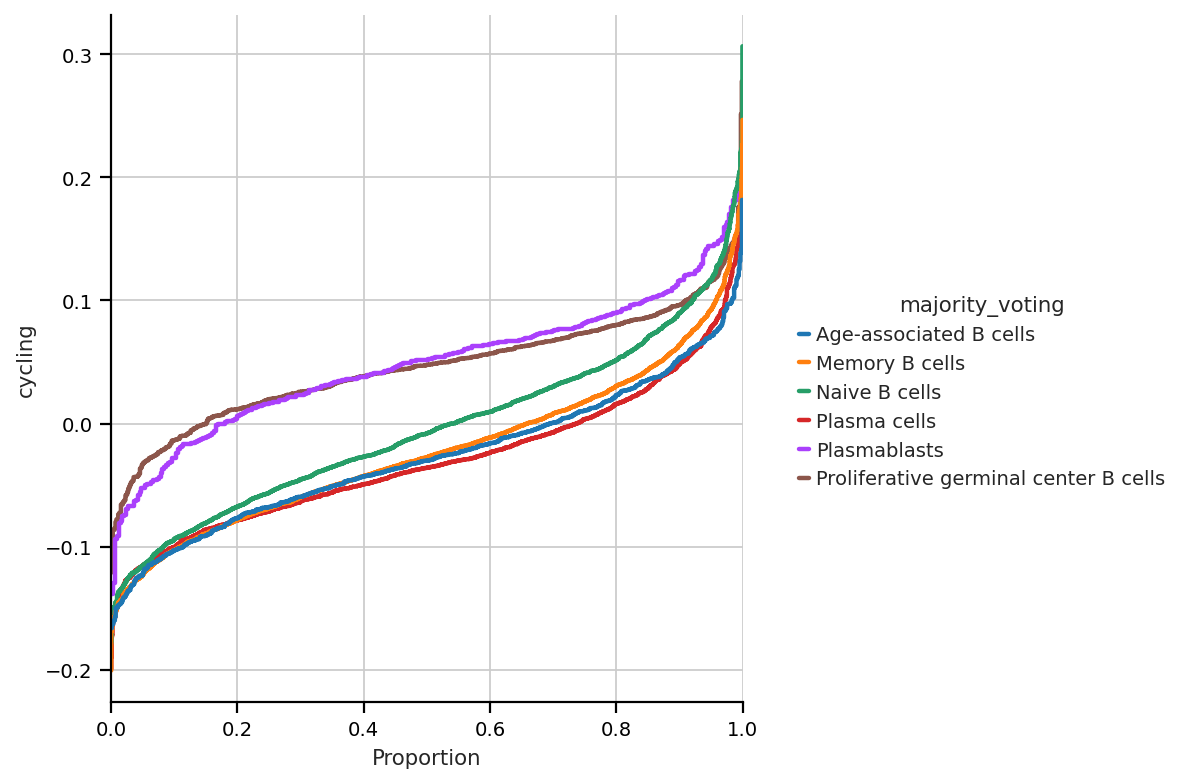

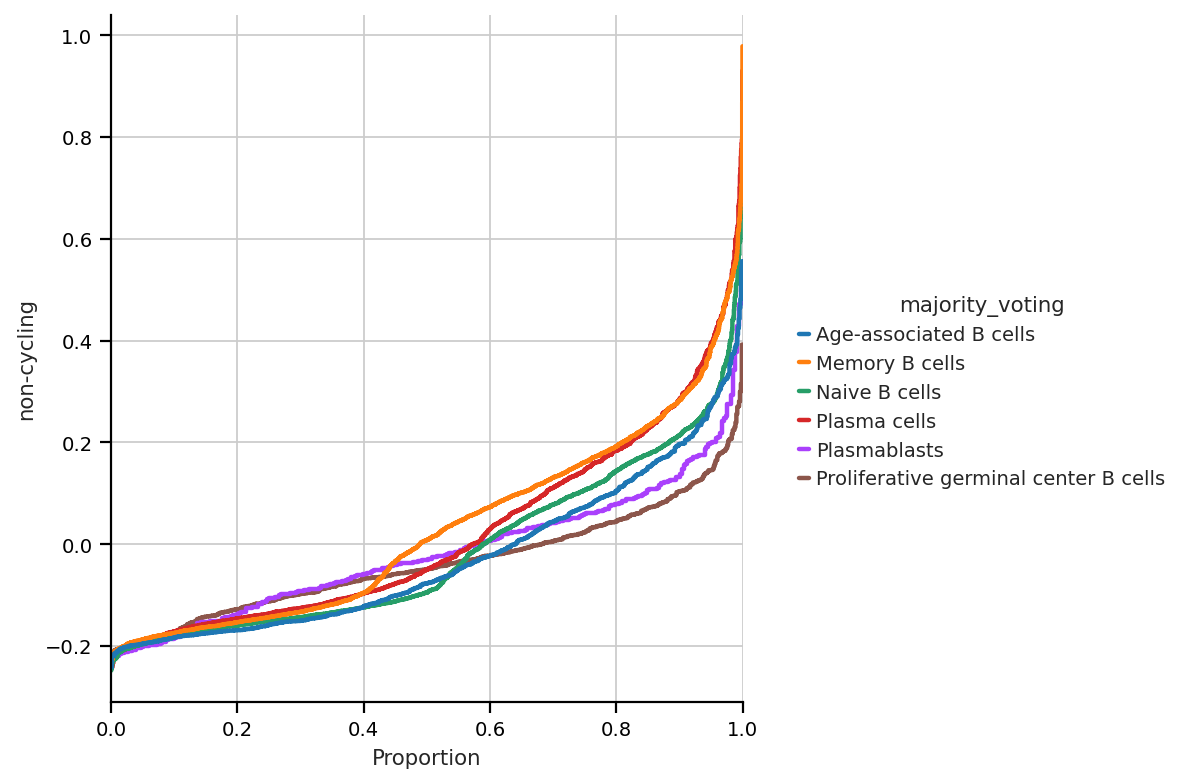

In [15]:
data = adata.obs
sns.displot(data = data, y = 'cycling', hue = 'majority_voting', kind = 'ecdf', lw = 2)
sns.displot(data = data, y = 'non-cycling', hue = 'majority_voting', kind = 'ecdf', lw = 2)

You do see some separation between the cycling cells and the non-cycling cells, but the signal is may be weak

## Plotting the joint distributions of Gita's Scores

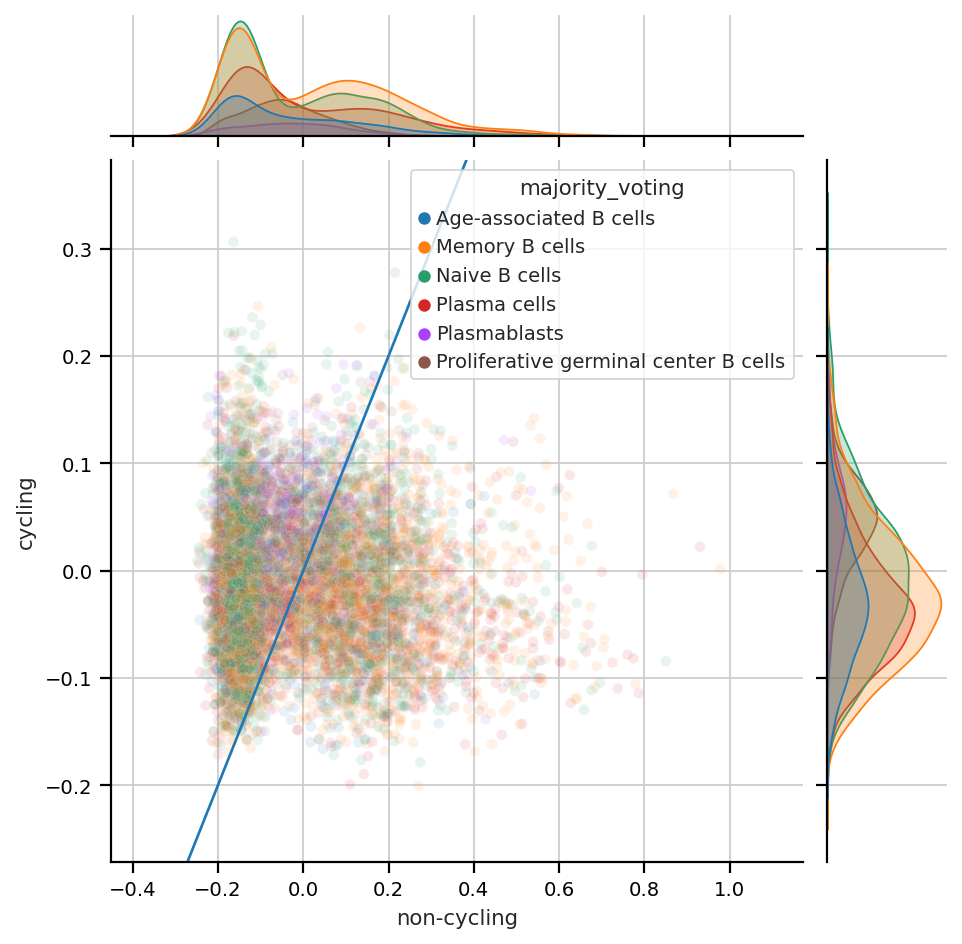

In [51]:
g = sns.jointplot(data = data, y = 'cycling', x = 'non-cycling', hue = 'majority_voting', lw = 2, alpha = 0.1)
g.ax_joint.axline((0, 0), slope=1)

# Annotate Cell Cycle via covariation Method

### Calculate the full correlation matrix of all genes

In [6]:
df = adata.to_df()

# convert cell x gene matrix to df
#df = convert_sparse_to_dataframe(adata)
# Use Numpy to do the Pearson Correllation of all values
# Did this because pandas corr is very slow, must be a bug.. 
# rowvar false means that genes are being correllated
df_corr = np.corrcoef(df.values, rowvar=False) 
# Put the labels back on and make it a df
df_corr = pd.DataFrame(df_corr, index = df.columns, columns=df.columns)
# Check that the matrix looks correct
df_corr.head()

In [7]:
GOI = 'MKI67'

### ECDF of pearson correlations of genes with Gene of interest

In [8]:
sns.set_context('paper')
g = sns.ecdfplot(y = df_corr[GOI], complementary=True, stat='count', lw = 2)
g.set_xscale('log')
print(df_corr[GOI].sort_values(ascending = True)[:10])

In [9]:
g = sns.ecdfplot(y = df_corr[GOI], complementary=False, stat='count', lw = 2)
g.set_xscale('log')
print(df_corr[GOI].sort_values(ascending = False)[:10])

Looks like hundreds of genes covary quite strongly with MKI67, let's peep the top 20 magnitidue pearson correlations

Seems that anti-correlated genes are a combo of B cell markers and anti profliferative genes e.g. DUSP1 and TSC22D3
Seems that correlated genes are related to the cell cycle e.g. TYMS, TPX2, AURKB

# Define Feature Set for Cell Cycle by taking strongest covarying Genes

In [11]:
# arbitraty cutoffs
cutoff = 0.5ax.axline((0, 0), slope=1)
cutoff_neg = -0.2

# all above cutoff
cell_cycle_genes = list(df_corr[df_corr[GOI] > cutoff][GOI].sort_values(ascending = False).index)

anti_cell_cycle_genes = list(df_corr[df_corr[GOI] < cutoff_neg][GOI].sort_values(ascending = False).index)

# balance the total amounts of each gene type
total_cc = len(cell_cycle_genes)
total_acc = len(anti_cell_cycle_genes)
if  total_cc <= total_acc:
    anti_cell_cycle_genes = anti_cell_cycle_genes[:total_cc]
else:
    cell_cycle_genes = cell_cycle_genes[:total_acc] 

# construct df to hold gene feature set 

cc = pd.DataFrame([cell_cycle_genes, anti_cell_cycle_genes]).T

cc.columns = ['cc', 'anti_cc']

cc.to_csv('cell_cycle_genes.tab', sep = "\t")

cell_cycle_genes = pd.read_table('cell_cycle_genes.tab', index_col=0)

In [17]:
# use a feature set that is the same size as the one Gita picked:
same_length = False
# use a larger feature set
genes_contributing_to_score = 20
if same_length:
    sc.tl.score_genes(adata, gene_list=cell_cycle_genes.loc[:len(cycling), 'cc'], score_name='correlation_cycling')
    sc.tl.score_genes(adata, gene_list=cell_cycle_genes.loc[:len(cycling), 'anti_cc'], score_name='anticorrelation_cycling')
else:
    sc.tl.score_genes(adata, gene_list=cell_cycle_genes.loc[:genes_contributing_to_score, 'cc'], score_name='correlation_cycling')
    sc.tl.score_genes(adata, gene_list=cell_cycle_genes.loc[:genes_contributing_to_score, 'anti_cc'], score_name='anticorrelation_cycling')


adata.obs['ms_cycling'] = adata.obs['correlation_cycling'] > 0.1

cycling_mapper = {True:'cycling', False:'non-cycling'}

adata.obs['ms_cycling'] = adata.obs['ms_cycling'].map(cycling_mapper)

/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


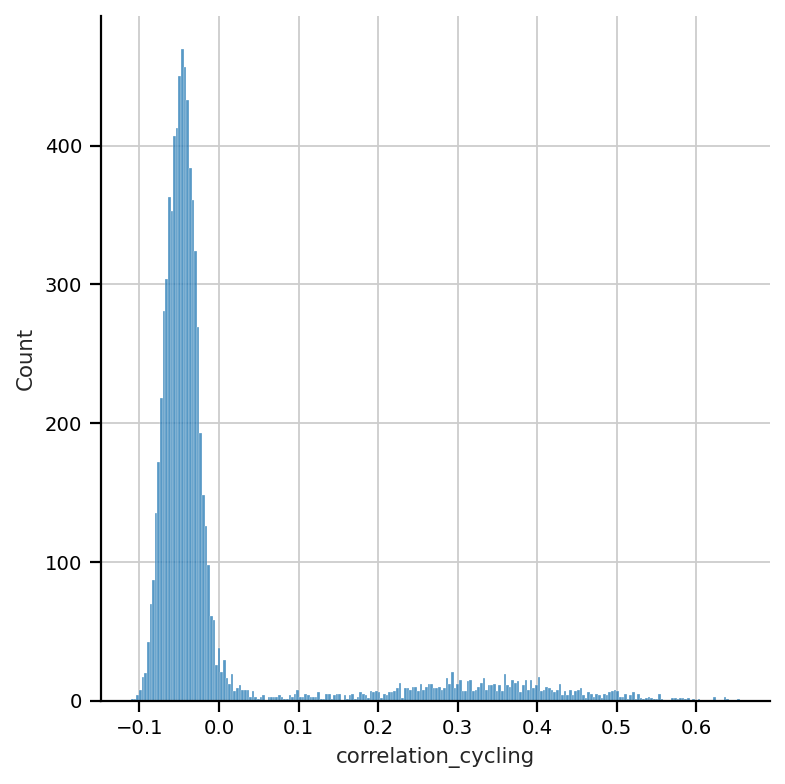

In [18]:
sns.displot(adata.obs['correlation_cycling'])
sns.displot(adata.obs['anticorrelation_cycling'])

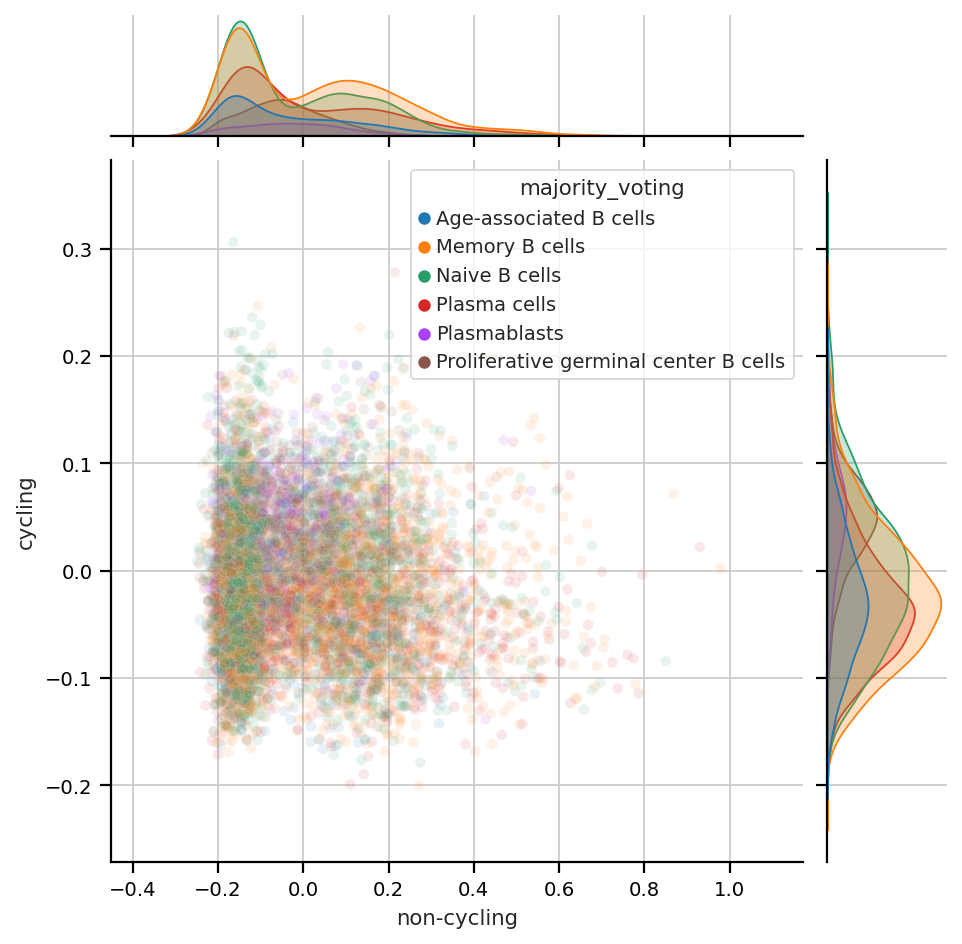

In [19]:
sns.jointplot(data = data, y = 'cycling', x = 'non-cycling', hue = 'majority_voting', lw = 2, alpha = 0.1)

## plot cell type labels onto these histograms to see if it checks out with biology

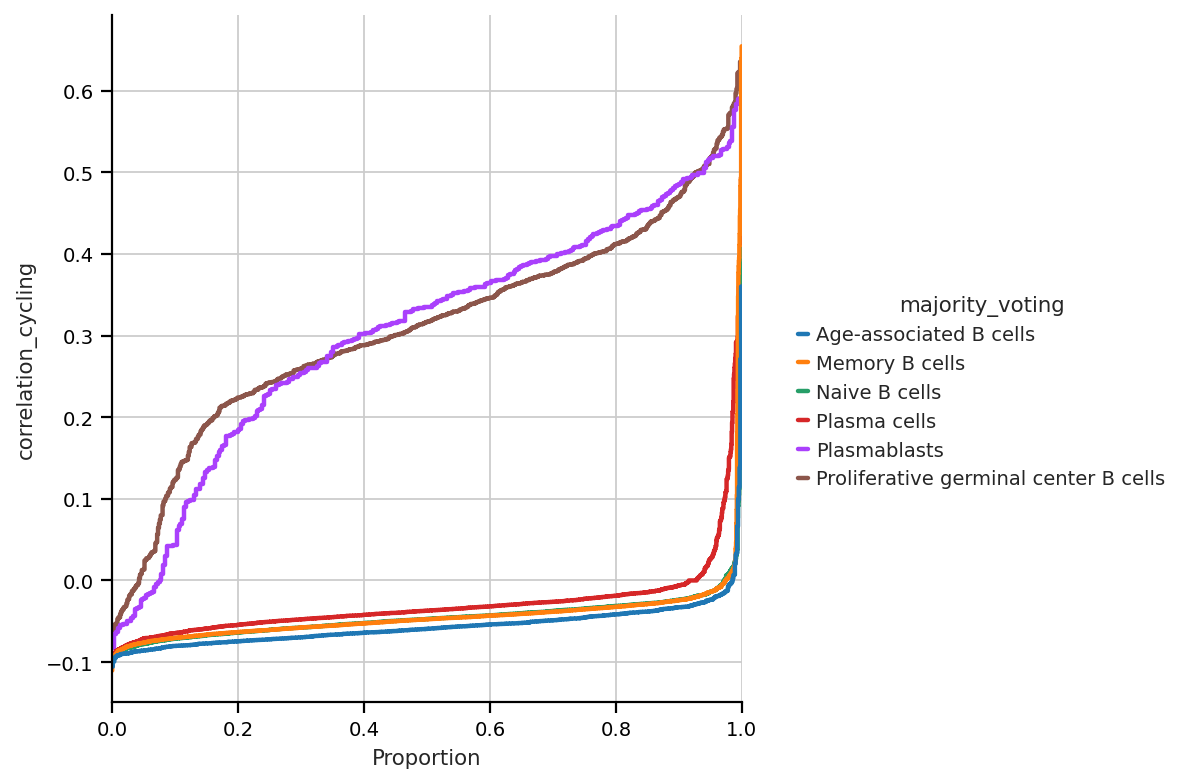

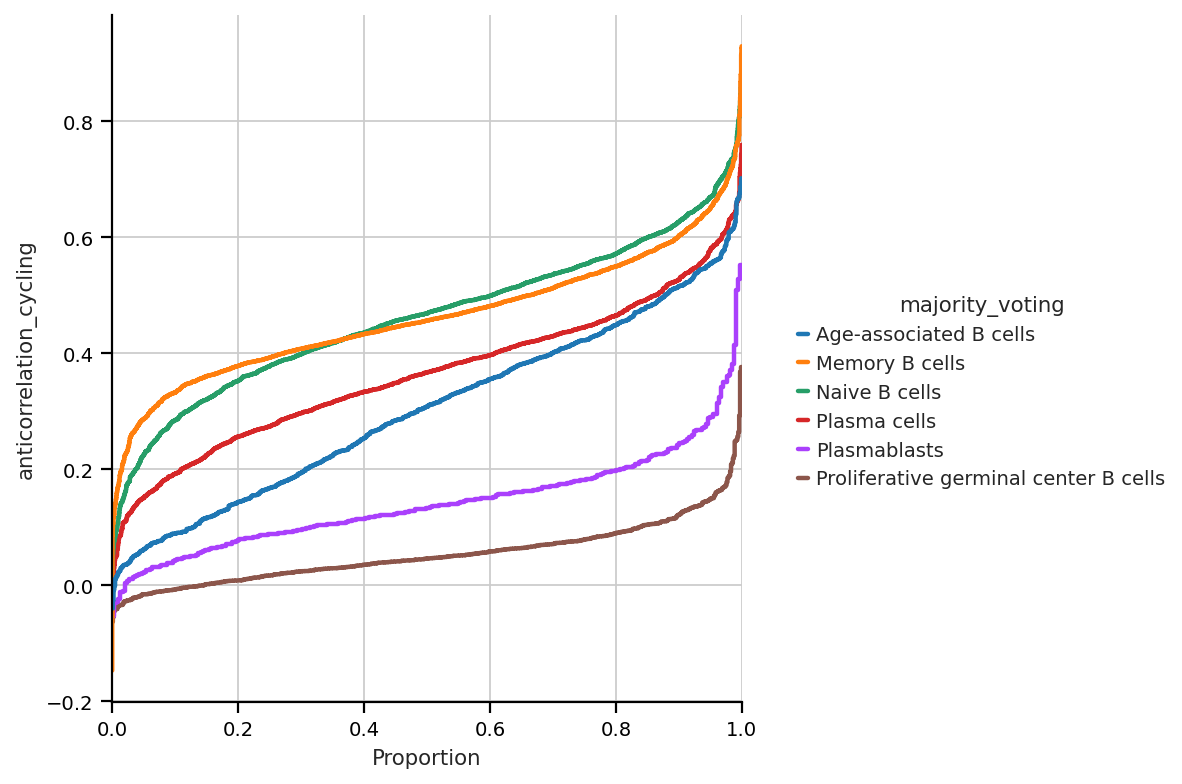

In [20]:
data = adata.obs
sns.displot(data = data, y = 'correlation_cycling', hue = 'majority_voting', kind = 'ecdf', lw = 2)
sns.displot(data = data, y = 'anticorrelation_cycling', hue = 'majority_voting', kind = 'ecdf', lw = 2)

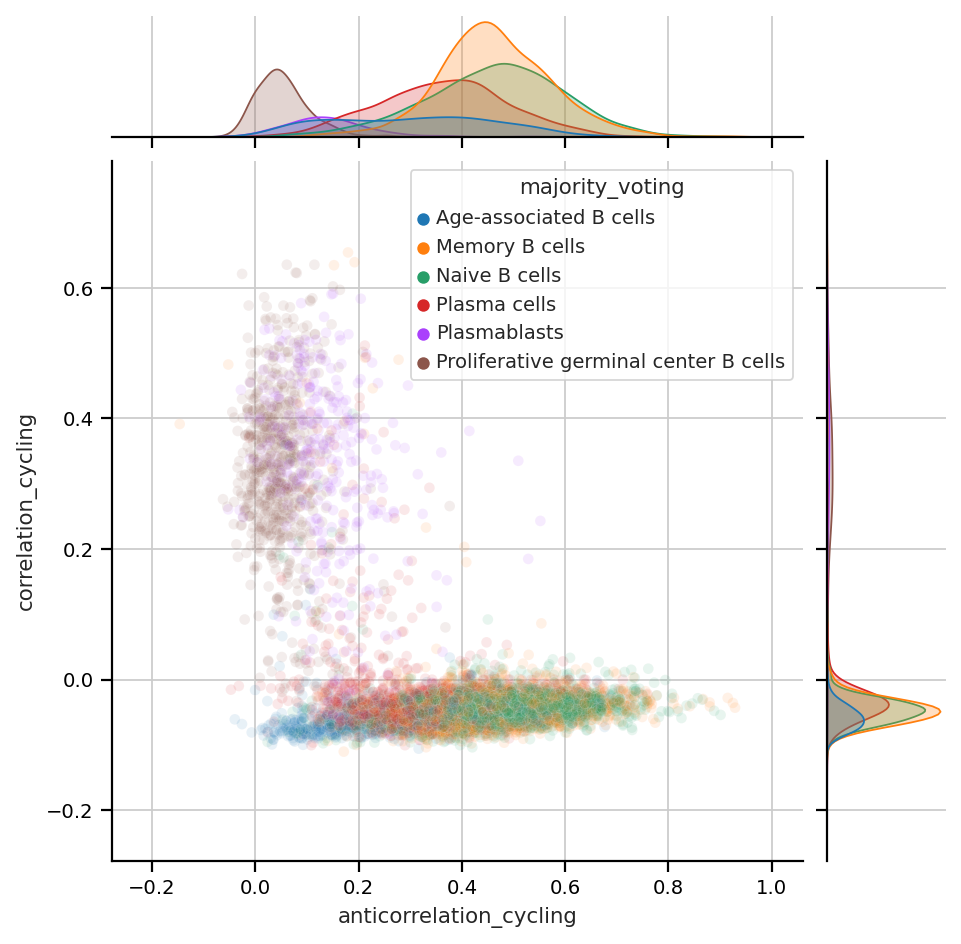

In [22]:
sns.jointplot(data = data, y = 'correlation_cycling', x = 'anticorrelation_cycling', hue = 'majority_voting', lw = 2, alpha = 0.1)

So here using the correlation approach, I can see a major problem with following Gita's lead and subtracting the scores because many of the anticorrelated genes I've identified are associated with Naive and Memory B cell identity, thus the plasma cells end up in the fourth quadrant, they certainly aren't cycling but they also aren't anti-cycling, I think it makes most sense to just use the positively correlated genes, but one good instead prune the anti-correlated genes to identify more relevant features to plasma cell anti-cycling and remove Mem/Naive identity genes

#  Plot classification schemes against each other

<AxesSubplot:xlabel='decision', ylabel='ms_cycling'>

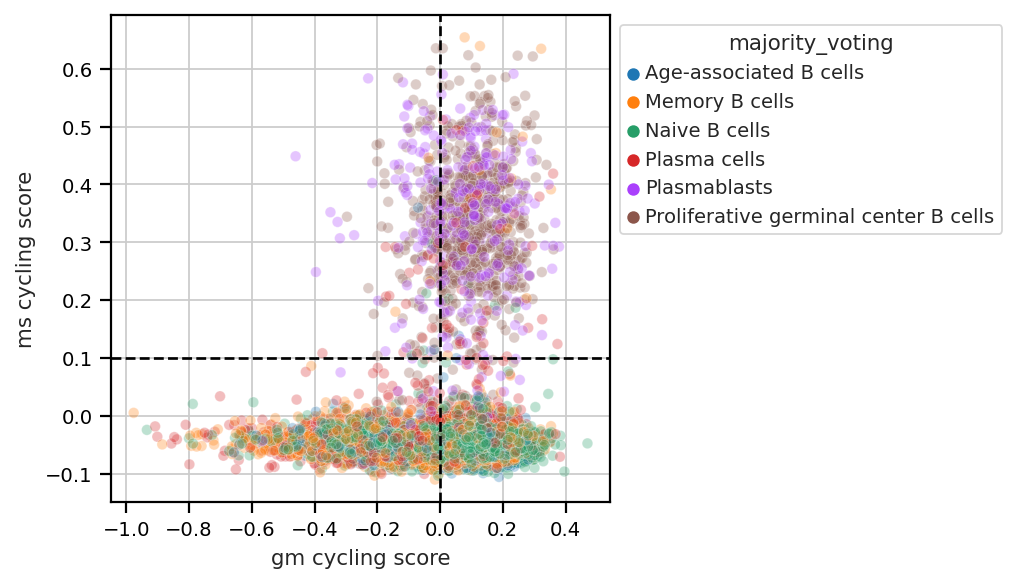

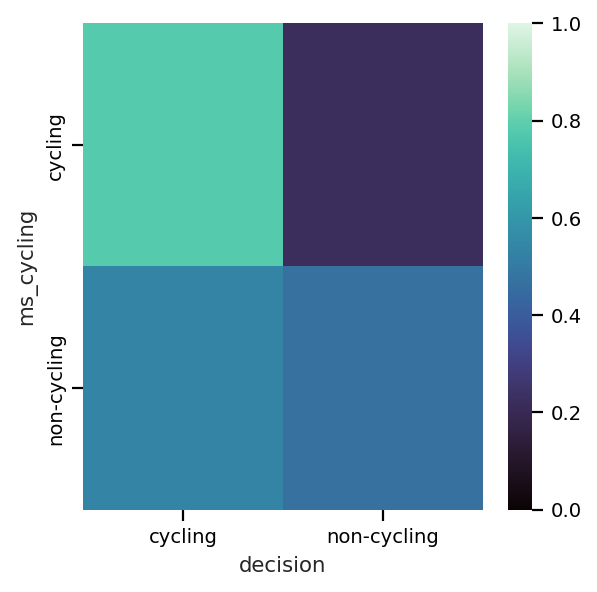

In [57]:
fig, ax = plt.subplots(1,1)
sns.scatterplot(adata.obs, x = adata.obs['cycling'] - adata.obs['non-cycling'], y = adata.obs['correlation_cycling'], alpha = 0.3, hue = adata.obs['majority_voting'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('gm cycling score')
plt.ylabel('ms cycling score')
plt.axvline(x=0, ls = "--", c = 'k')
plt.axhline(y=0.1, ls = "--", c = 'k')
fig, ax = plt.subplots(1,1)
cmtx = sc.metrics.confusion_matrix("ms_cycling", "decision", adata.obs)
sns.heatmap(cmtx, cmap='mako', vmax = 1 , vmin = 0)

### Plotting all four scores against each other 

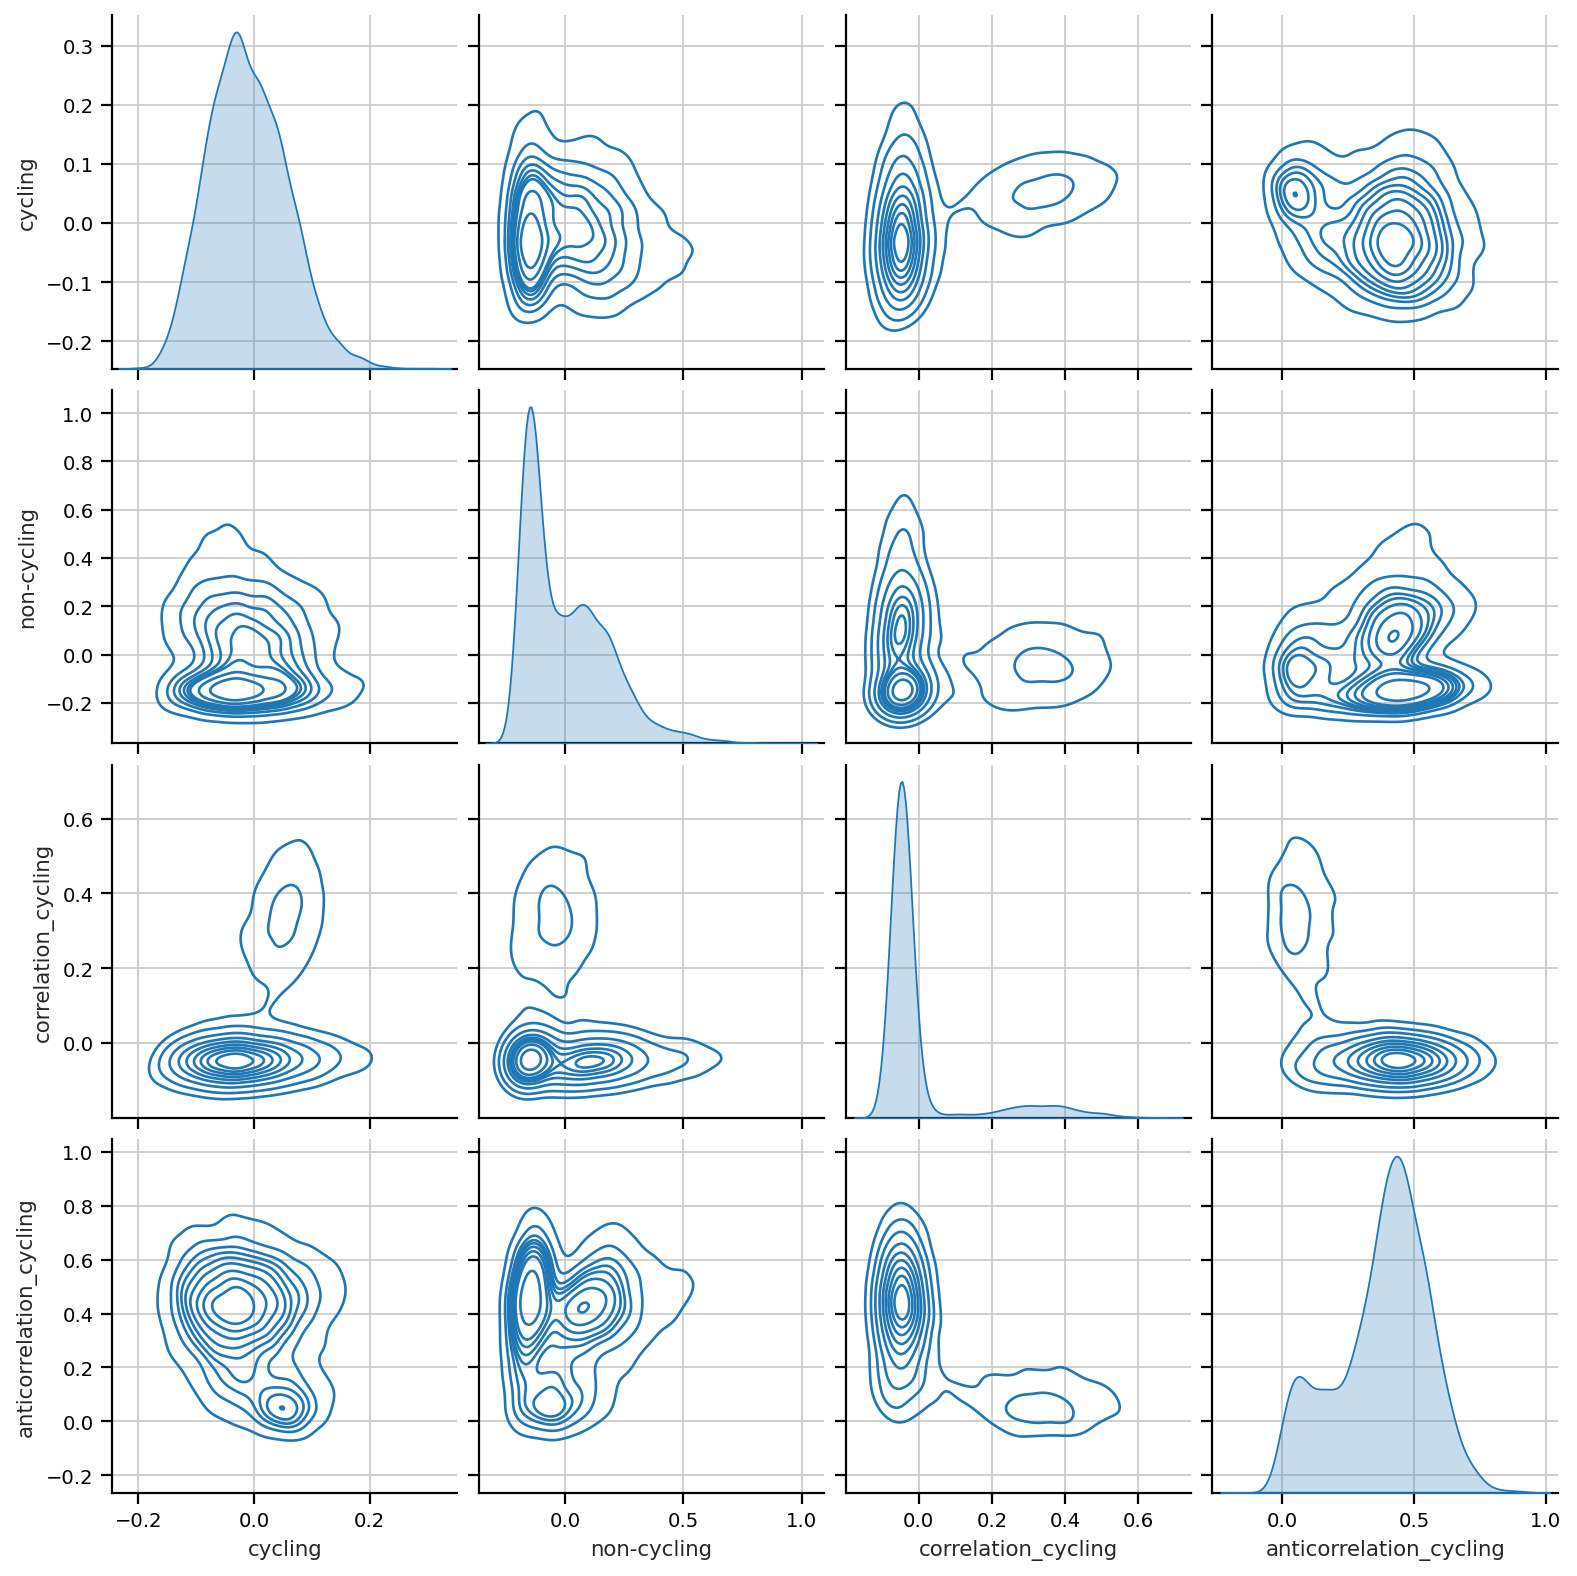

In [25]:
x_vars = ['cycling', 'non-cycling', 'correlation_cycling', 'anticorrelation_cycling']
y_vars = ['cycling', 'non-cycling', 'correlation_cycling', 'anticorrelation_cycling']
sns.pairplot(data = adata.obs, x_vars=x_vars, y_vars=y_vars, kind="kde")

## Look at correlations between cell gene expression signatures using the cell cycle subset

In [40]:
include_anticorrelated = False
if include_anticorrelated:
    df_sub = df[pd.concat([cell_cycle_genes['cc'], cell_cycle_genes['anti_cc']]).dropna().to_list()]
else:
    df_sub = df[cell_cycle_genes['cc'].to_list()]
df_corr_cc = np.corrcoef(df_sub.values, rowvar=True) 
# Put the labels back on and make it a df
df_corr_cc = pd.DataFrame(df_corr_cc, index = df.index, columns=df.index)
# Check that the matrix looks correct
df_corr_cc.head()

AACTCTTCAAATTGCC-1  CTCGAAATCACCTTAT-1-4  TGCGCAGAGGTGTGGT-1  TTCTTAGCAGGTTTCA-1-1  CACAGGCTCATGTCTT-1-2  CACAGGCGTATAGGGC-1  CGTCACTCAGACAAAT-1  GTCGTAAAGCGATTCT-1  ATTATCCAGCGGCTTC-1-2  CAGTCCTAGTTGAGTA-1  ACCAGTATCCGAACGC-1  TCTGGAATCGCTAGCG-1  GGGATGACAGCTGTGC-1  CAGCTAAGTCATATCG-1  GTGGGTCAGCGAGAAA-1-2  CGTTGGGGTGTGCGTC-1  AGCGGTCTCAGGCGAA-1-2  GTAGGCCGTCTGCGGT-1-1  GAATAAGCATGCCTTC-1  GTGTGCGTCGATAGAA-1  ACGAGCCAGCCCTAAT-1  CGCGTTTCAACAACCT-1  CCGTGGATCAGCGACC-1  TCGCGTTAGCTGGAAC-1  CGGAGCTTCATCGATG-1-1  TGACGGCAGGAGCGTT-1  TTCCCAGTCCACGAAT-1  CCAATCCGTCGGGTCT-1  TGGTTAGCAGGACCCT-1  TGGCCAGCAAACGTGG-1-1  TATCTCACAGTGGAGT-1  GCAGTTAGTGGCAAAC-1-1  ACATGGTCACACTGCG-1  TGTGTTTAGAGACGAA-1  ATCCACCGTAGTGAAT-1-1  GCTGGGTCATATGCTG-1  GTCCTCAGTCACCCAG-1  ACGATACTCGGTGTCG-1-1  GTATTCTGTCGCATAT-1  CCTACACAGCAGCGTA-1-1  TCATTACAGGAATCGC-1  GTGAAGGGTAGGGACT-1  CCATTCGCACCGATAT-1  ACAGCCGCAGCTGTGC-1  TGACTTTCAAATCCGT-1-1  CATTCGCTCACGATGT-1  TTGCCGTAGTAGGCCA-1  \
AACTCTTCAAATTGCC-1              1.000000             -0.059117            0.007679              0.007679             -0.018467           -0.069650           -0.029968           -0.005796             -0.055954            0.161472           -0.028425            0.992904           -0.038088           -0.013168              0.007679           -0.014439             -0.014245             -0.034983           -0.038449            0.007679           -0.031011           -0.039437            0.007679           -0.060149             -0.019369           -0.004454           -0.029502           -0.056865           -0.043157             -0.027186            0.103723              0.133879            0.007679            0.067836             -0.076359           -0.022029           -0.029445             -0.014439           -0.024923             -0.021102           -0.023520           -0.002450            0.007679            0.007679             -0.023368            0.022966           -0.023785   
CTCGAAATCACCTTAT-1-4           -0.059117              1.000000           -0.125335             -0.125335             -0.031939            0.110474            0.074276           -0.017749             -0.001758           -0.090357            0.082709           -0.063525            0.126836           -0.028925             -0.125335           -0.038569             -0.038286             -0.081016            0.113503           -0.125335            0.005032           -0.074345           -0.125335            0.003390             -0.036540           -0.023999           -0.078208            0.049384           -0.068624             -0.047565           -0.149336              0.026050           -0.125335           -0.061935              0.298751           -0.051809           -0.044902             -0.038569           -0.051061             -0.043449           -0.045011           -0.021074           -0.125335           -0.125335             -0.026225            0.111947           -0.060464   
TGCGCAGAGGTGTGGT-1              0.007679             -0.125335            1.000000              1.000000              0.119210           -0.254103            0.024949            0.164503             -0.112482           -0.149927            0.035774           -0.028092           -0.033748            0.115963              1.000000            0.119023              0.120372              0.062065            0.005136            1.000000            0.092838           -0.000106            1.000000           -0.172425              0.094516            0.188619            0.135504           -0.174463           -0.062870              0.029062           -0.006248             -0.164260            1.000000            0.042666             -0.054883            0.081003            0.040023              0.119023            0.058549              0.077545            0.076746            0.202594            1.000000            1.000000              0.110830           -0.125993            0.110627   
TTCTTAGCAGGTTTCA-1-1            0.007679             -

In [34]:
# downsample df for clustermap
_data = df_corr_cc.sample(n=2500, replace=False)

In [35]:
clusterplot = _data[_data.index]

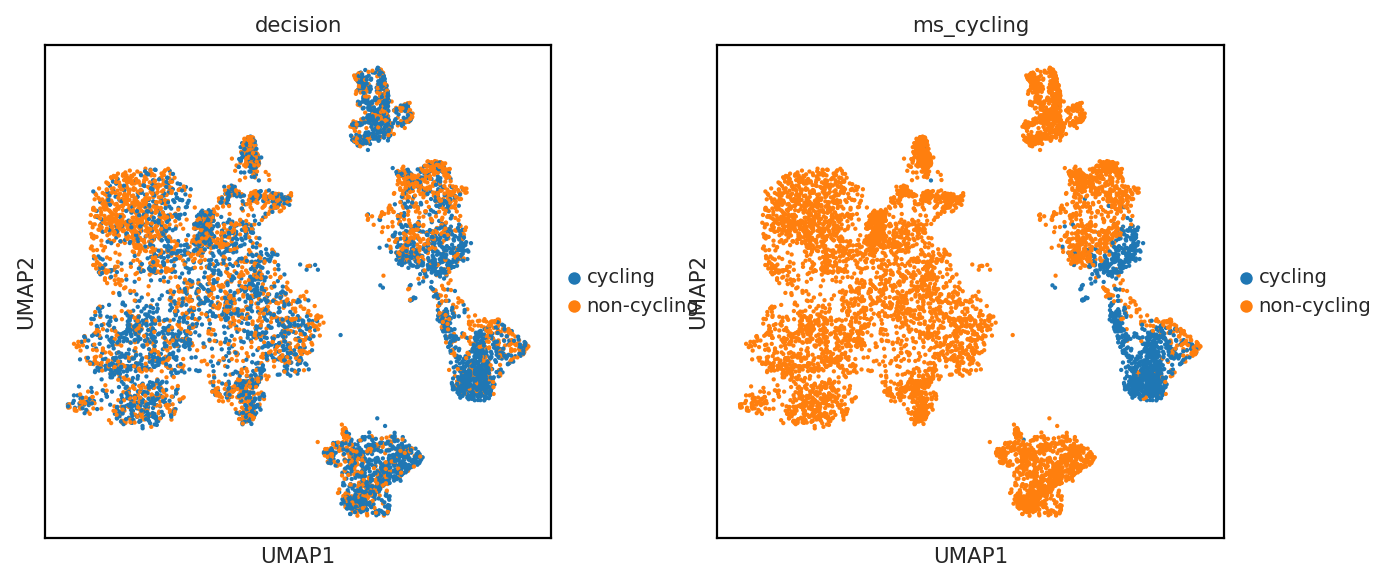

In [36]:
sc.pl.umap(adata, color = ['decision', 'ms_cycling'])

/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


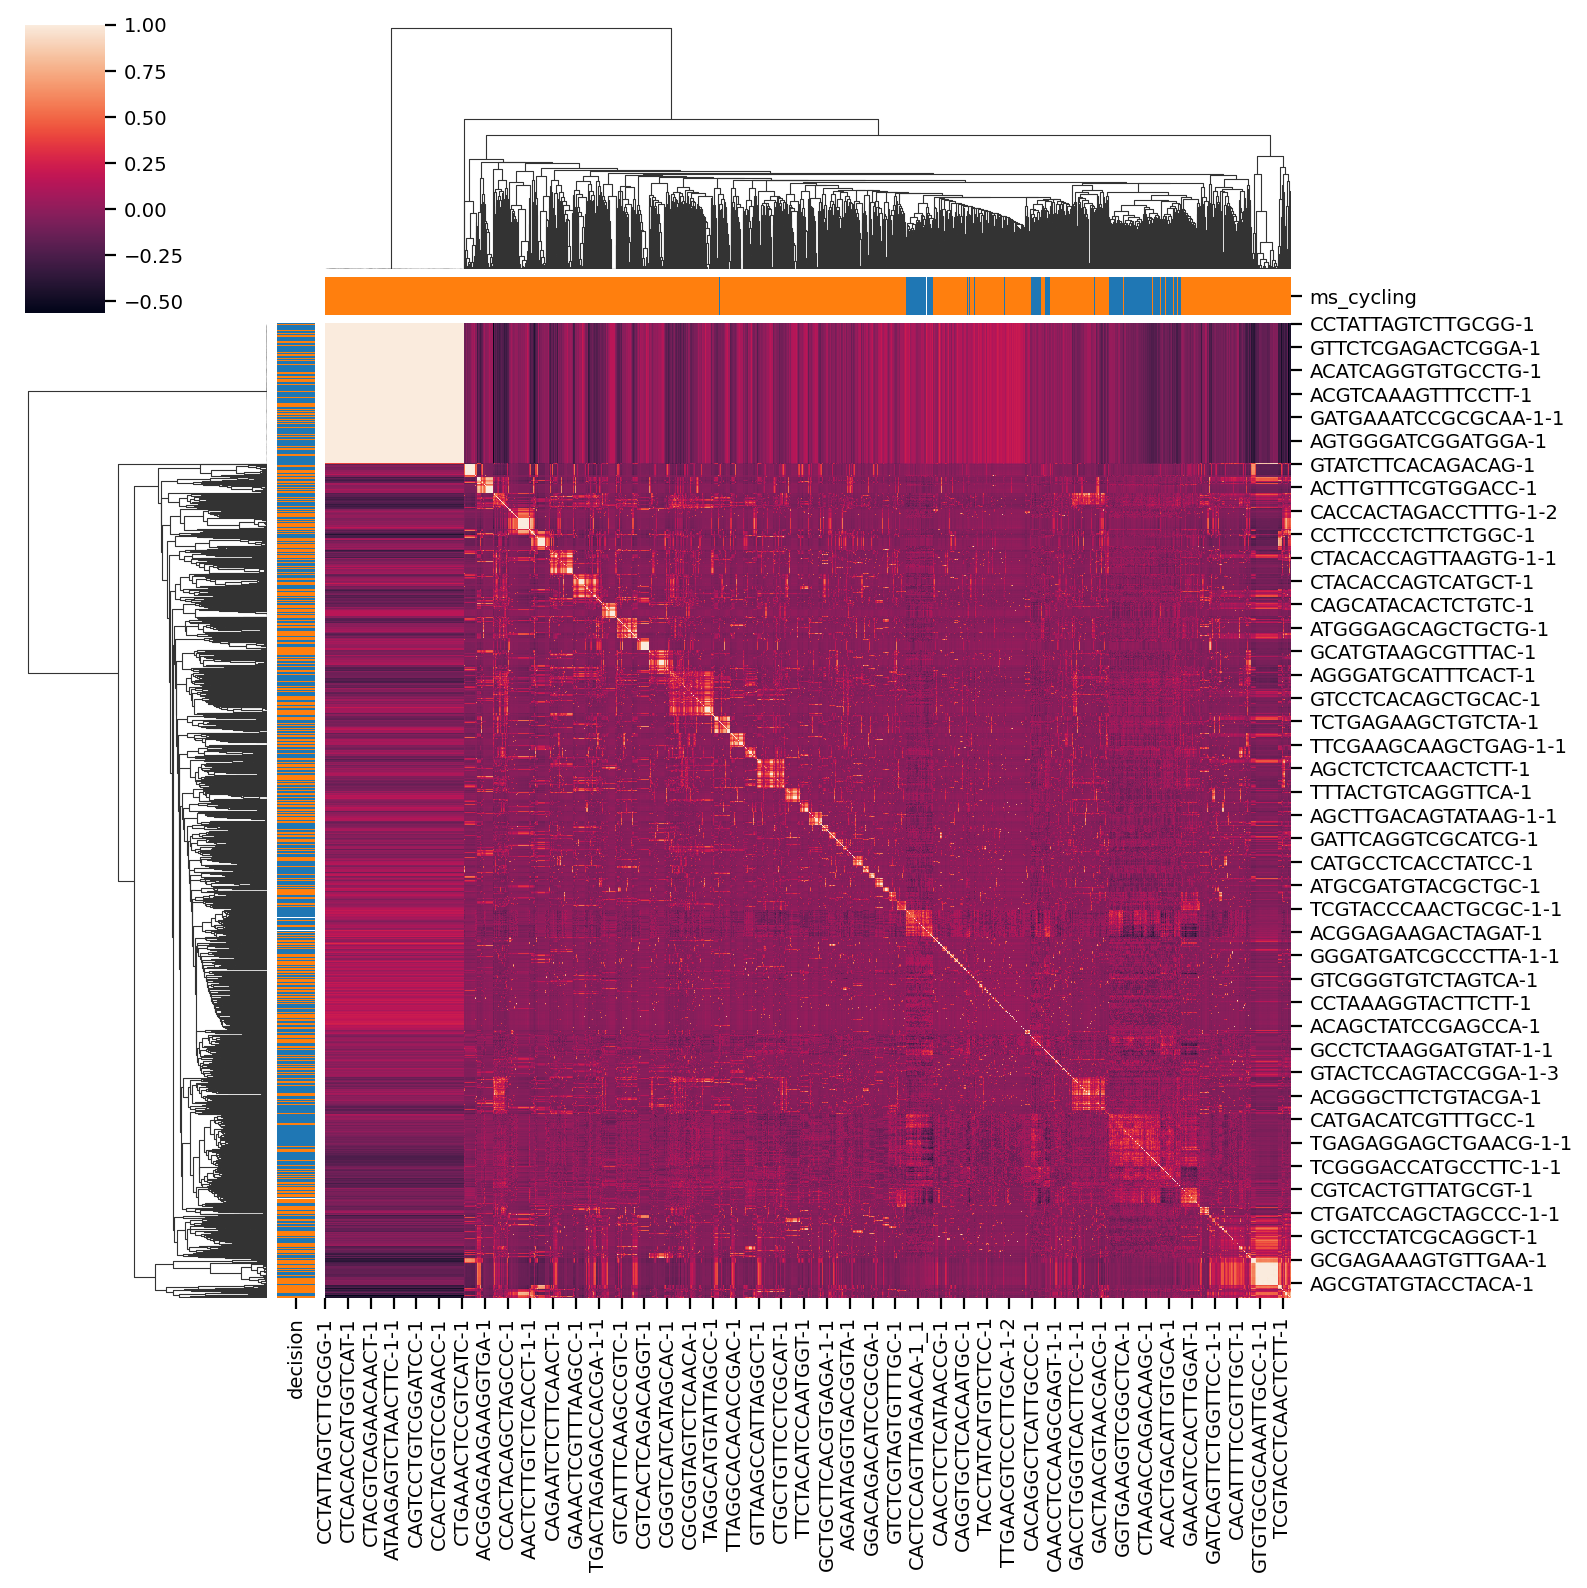

In [37]:
label1 = 'decision'
label2 = 'ms_cycling'
mapper1 = dict(zip(adata.obs[label1].unique().sort_values().to_list(), adata.uns['{}_colors'.format(label1)]))
mapper2 = dict(zip(adata.obs[label2].unique().sort_values().to_list(), adata.uns['{}_colors'.format(label2)]))

sns.clustermap(clusterplot, row_colors=adata.obs[label1].map(mapper1), col_colors=adata.obs[label2].map(mapper2))

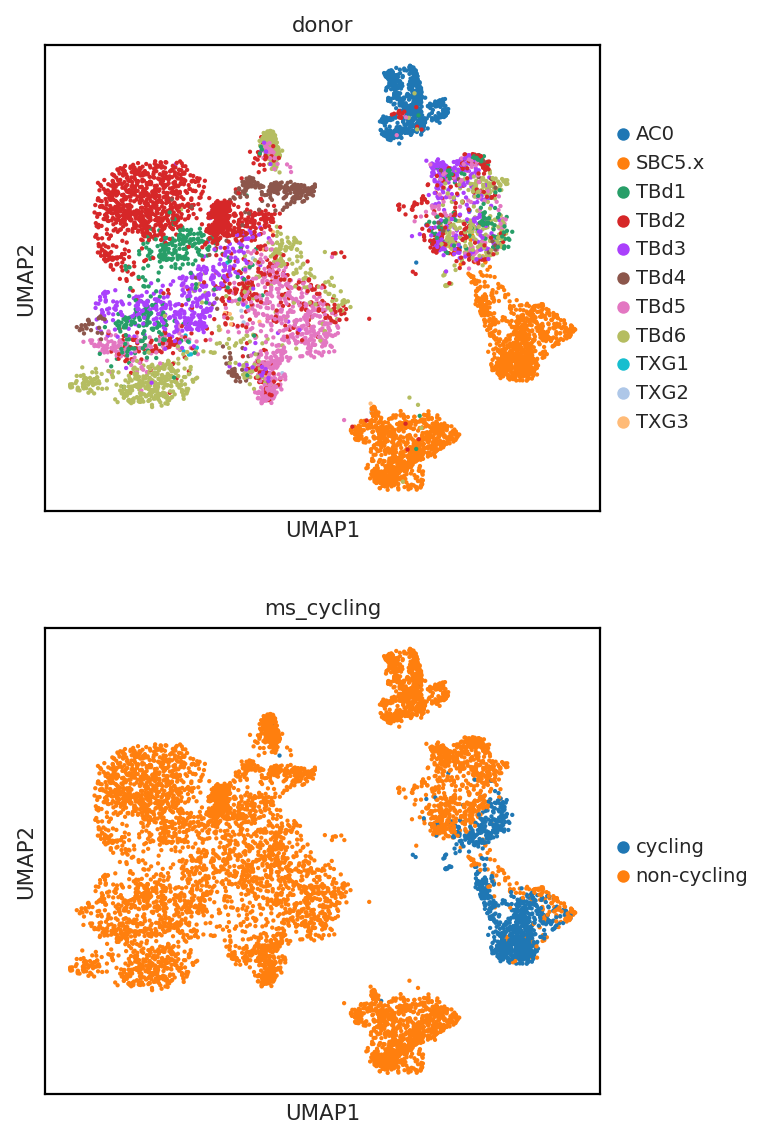

/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


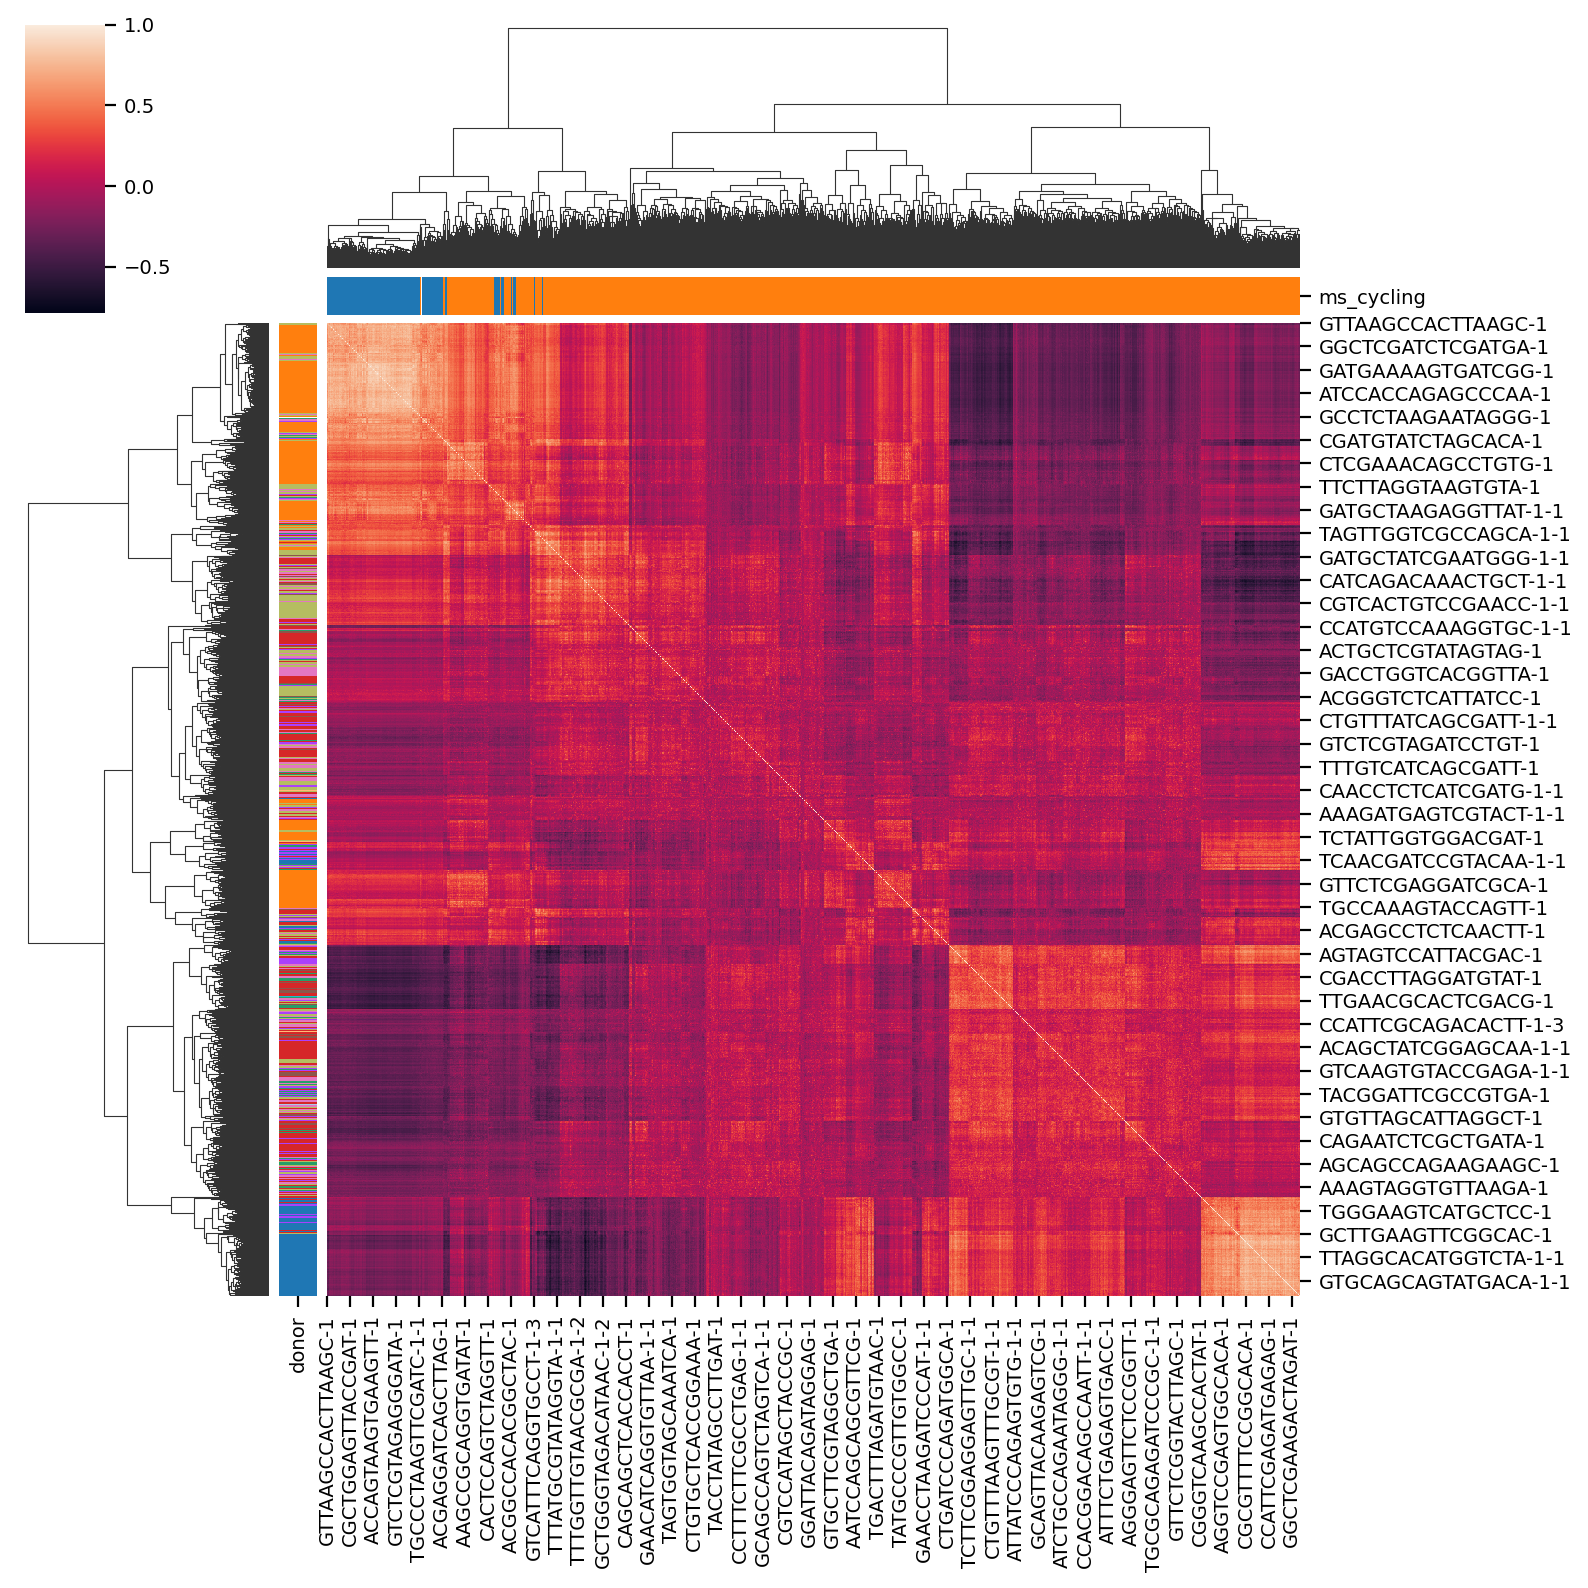

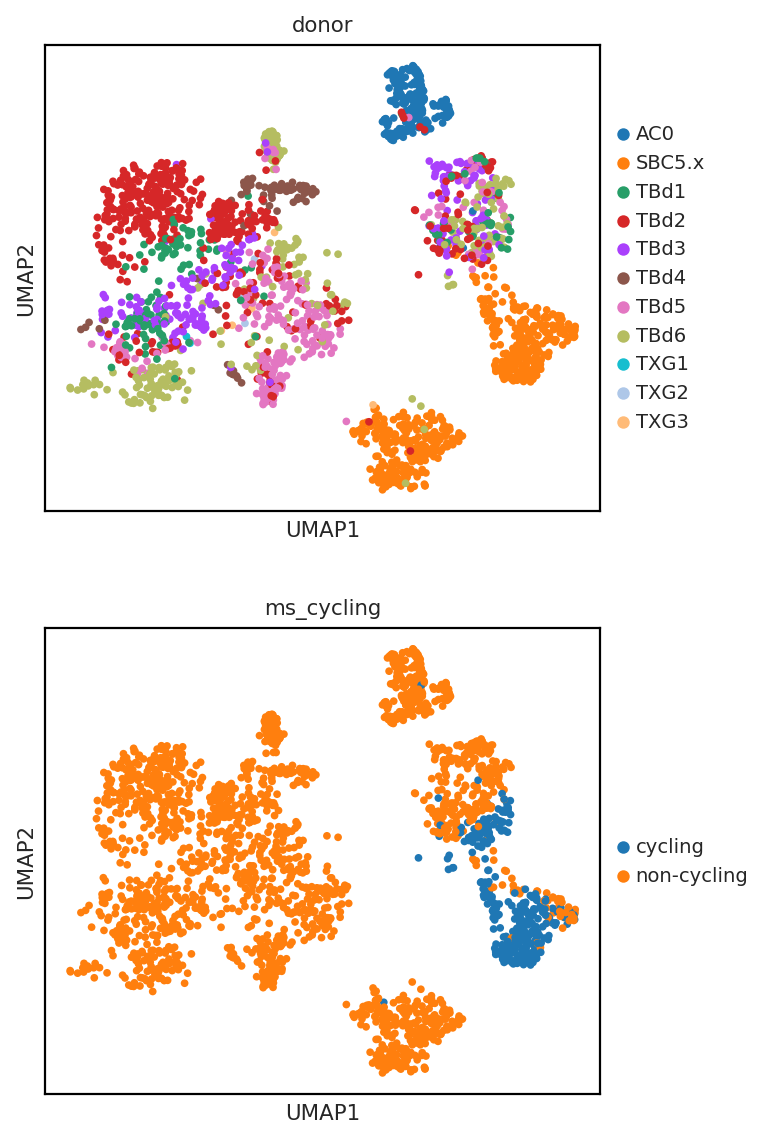

In [31]:
label1 = 'donor'
label2 = 'ms_cycling'
sc.pl.umap(adata,color = [label1, label2], ncols=1)
mapper1 = dict(zip(adata.obs[label1].unique().sort_values().to_list(), adata.uns['{}_colors'.format(label1)]))
mapper2 = dict(zip(adata.obs[label2].unique().sort_values().to_list(), adata.uns['{}_colors'.format(label2)]))

sns.clustermap(clusterplot, row_colors=adata.obs[label1].map(mapper1), col_colors=adata.obs[label2].map(mapper2))
sc.pl.umap(adata[adata.obs.index.isin(clusterplot.index)], color = [label1, label2], ncols=1)

In [32]:
label1 = 'majority_voting'
label2 = 'MKI67+'
mapper1 = dict(zip(adata.obs[label1].unique().sort_values().to_list(), adata.uns['{}_colors'.format(label1)]))
mapper2 = dict(zip(adata.obs[label2].unique().sort_values().to_list(), adata.uns['{}_colors'.format(label2)]))

sns.clustermap(clusterplot, row_colors=adata.obs[label1].map(mapper1), col_colors=adata.obs[label2].map(mapper2))
sc.pl.umap(adata[adata.obs.index.isin(clusterplot.index)], color = [label1, label2], ncols=1)

KeyError: 'majority_voting_colors'

In [ ]:
label1 = 'majority_voting'
label2 = 'donor'
mapper1 = dict(zip(adata.obs[label1].unique().sort_values().to_list(), adata.uns['{}_colors'.format(label1)]))
mapper2 = dict(zip(adata.obs[label2].unique().sort_values().to_list(), adata.uns['{}_colors'.format(label2)]))
sns.clustermap(clusterplot, row_colors=adata.obs[label1].map(mapper1), col_colors=adata.obs[label2].map(mapper2))
sc.pl.umap(adata[adata.obs.index.isin(clusterplot.index)], color = [label1, label2], ncols=1)

In [ ]:
label1 = 'llpc'
label2 = 'MKI67+'
mapper1 = dict(zip(adata.obs[label1].unique().sort_values().to_list(), adata.uns['{}_colors'.format(label1)]))
mapper2 = dict(zip(adata.obs[label2].unique().sort_values().to_list(), adata.uns['{}_colors'.format(label2)]))

sns.clustermap(clusterplot, row_colors=adata.obs[label1].map(mapper1), col_colors=adata.obs[label2].map(mapper2))
sc.pl.umap(adata[adata.obs.index.isin(clusterplot.index)], color = [label1, label2], ncols=1)

# Plot the long lived Plasma Cells; are the proliferating homeostatically?

In [ ]:
sub_adata = adata[adata.obs.majority_voting.str.contains('Plasma')]

In [ ]:
llpc_genes = ['CD19', 'MS4A1', 'CD38', 'SDC1', 'MKI67']

In [ ]:
sc.pl.violin(sub_adata, keys=['CD19', 'MS4A1', 'CD38', 'SDC1', 'MKI67'], groupby='llpc')

In [ ]:
sc.pl.umap(adata, color=llpc_genes + ['llpc'])

# PCA on MKI67 correlated genes 

In [ ]:
adata = sc.read_h5ad('by_tissue_qc/bcells_BCD.h5ad')
adata.obs_names_make_unique(join="_")
sc.pp.subsample(adata, fraction=0.5)


In [ ]:
cc = pd.read_table("cell_cycle_genes.tab", index_col=0)

In [ ]:
_genes = pd.Series(cc.values.flatten()).dropna()

In [ ]:
adata.X = adata.layers['umi_counts']

pearson_residuals = True
if pearson_residuals:
    adata = adata[:,~adata.var.index.str.contains("IGH|IGL|IGK|AC|AL")].copy()
    adata = adata[:, adata.var.index.isin(_genes)].copy()
    adata.raw = adata
    sc.experimental.pp.recipe_pearson_residuals(adata, batch_key='tissue')
else:
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata

### light-weight batch correction by choosing HVGs from different tissues

sc.pl.pca_overview(adata)

## Subset the AnnData Object and ask whether there are multiple modules of these cell cycle correlated genes

Point here is that many of the cell cyle genes are not considered highly variable an thus aren't contributing to the embedding which is odd to me, would like to take the intersection of hvg and cell cycle at some point

In [ ]:
sub_adata = adata[:,adata.var.index.isin(cell_cycle_genes)]

In [ ]:
# just the cell cycle genes
df_cc = df[cell_cycle_genes]

In [ ]:
columns = df_cc.columns
rows = df_cc.index

In [ ]:
corr = np.corrcoef(df_cc.values) 

In [ ]:
hvgs = set(adata.var[adata.var.highly_variable == True].index)

genes = hvgs | set(cell_cycle_genes)

df_corr.dropna(thresh = 2)

In [ ]:
clustermap = df_corr.loc[list(cell_cycle_genes), list(cell_cycle_genes)]

In [ ]:
sns.clustermap(clustermap)

In [ ]:
sc.pl.pca_overview(adata)

## Now Load full object

In [ ]:
adata = sc.read_h5ad('by_tissue_qc/bcells_BCD.h5ad')

In [ ]:
adata = adata[adata.obs.predicted_label.str.contains('Plasma|B cells')]

In [ ]:
sc.tl.score_genes(adata, gene_list=cell_cycle_genes, score_name = "cycling_score")

In [ ]:
sc.pl.umap(adata, color = 'cycling_score')

In [ ]:
sns.set_context('paper')
g = sns.ecdfplot(data = adata.obs, y = "cycling_score", hue = 'leiden', complementary=True, stat='proportion', lw=2)
g.set_xscale('log')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
sns.set_context('paper')
g = sns.ecdfplot(data = adata.obs, y = "cycling_score", hue = 'leiden', complementary=True, stat='count', lw=2)
g.set_xscale('log')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
sns.set_context('paper')
g = sns.ecdfplot(data = adata.obs, y = "cycling_score", hue = 'predicted_label', complementary=True, stat='proportion', lw = 2)
g.set_xscale('log')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
g = sns.displot(data = adata.obs, y = "cycling_score", hue = 'predicted_label')

In [ ]:
sns.set_context('paper')
g = sns.ecdfplot(data = adata.obs, y = "cycling_score", hue = 'predicted_label', complementary=True, stat='count', lw = 2)
g.set_xscale('log')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
sc.pl.umap(adata, color = 'leiden')

In [ ]:
adata.obs.loc[:, 'cycling'] = adata.obs.cycling_score > 0.1

In [ ]:
import celltypist
from celltypist import models

In [ ]:
def plot_model_description(adata, predicted_label):
    models.models_description()

    model = models.Model.load(model = '/home/michaelswift/.celltypist/data/models/Immune_All_Low.pkl')
    top_genes = model.extract_top_markers(predicted_label, 15)
    # sometimes top genes aren't in adata.var, which is odd but w/e
    top_genes = adata.var.index[adata.var.index.isin(top_genes)]
    sc.pl.umap(adata, color = list(top_genes))
    # these genes doen't appear specific, a B cell

In [ ]:
plot_model_description(adata, "Plasma cells")

plot_model_description(adata, "Proliferative germinal center B cells")

In [ ]:
GROUP = 'leiden'

sc.tl.rank_genes_groups(adata, groupby=GROUP)

sc.pl.umap(adata, color = GROUP, size = 20)

sc.pl.rank_genes_groups(adata)

In [ ]:
GROUP = 'donor'

sc.tl.rank_genes_groups(adata, groupby=GROUP)

sc.pl.umap(adata, color = GROUP, size = 20)

sc.pl.rank_genes_groups(adata)

In [ ]:
adata.obs.cycling = adata.obs.cycling.astype(str)

In [ ]:
sc.pl.umap(adata, color = ['tissue', 'FCRL4', 'CD27', "MS4A1", 'cycling'], size = 10)


# Investigate the Plasma Cell Cycling

In [ ]:
plasma = adata[adata.obs.predicted_label.str.contains("Plasma")]

In [ ]:
sc.pl.umap(plasma, color = 'cycling')

In [ ]:
def highly_variable_noIR(adata, n_top_genes):
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)
    adata.var.loc[adata.var.index.str.contains("IGHV|IGLV|IGKV"), 'highly_variable'] = False
    return adata

In [ ]:
plasma = highly_variable_noIR(plasma, n_top_genes=1500)

In [ ]:
sc.pp.pca(plasma)
sc.pp.neighbors(plasma)
sc.tl.umap(plasma)
sc.tl.leiden(plasma, resolution=0.7)

In [ ]:
plasma.uns['leiden_colors'] = []

In [ ]:
sc.tl.rank_genes_groups(plasma, groupby='leiden', reference = '1')

In [ ]:
sc.pl.rank_genes_groups(plasma)

In [ ]:
sc.pl.umap(plasma, color = ['predicted_label'])

In [ ]:
sc.pl.umap(plasma, color = ['leiden', 'cycling','CD19', 'SDC1', "CD27", "CD38"])

In [ ]:
sc.pl.umap(plasma, color = ['leiden', 'cycling', 'SSR4', 'FNDC3B', "CD69", 'SDC1', "JCHAIN","AFF3", "DUSP1", "IGHM", "IGHD", 'tissue', 'ZBP1', 'donor', "IGHA1", "ADA2", "CD38"])

In [ ]:
sc.pl.umap(plasma, color = ['leiden', 'cycling', 'SSR4', 'FNDC3B', "CD69", 'SDC1', "JCHAIN","AFF3", "DUSP1", "IGHM", "IGHD", 'tissue', 'ZBP1', 'donor', "IGHA1", "ADA2", "CD38"])

In [ ]:
data = adata.obs

In [ ]:
## Make plot of cycling vs non-cycling cells in ASC compartment

In [ ]:
data = data[data.predicted_label.str.contains("Plasma")]

In [ ]:
sns.catplot(data = data, kind = 'count', x = "cycling", hue = 'tissue', col='donor')

In [ ]:
sns.catplot(data = data, kind = 'count', x = "cycling", col='tissue')

In [ ]:
sns.catplot(data = data, kind = 'count', x = "cycling", hue = 'donor', col='tissue')